<a href="https://colab.research.google.com/github/Tigi-koko/Favorita-Store-Forcasting/blob/main/Favorita_Corporaci%C3%B3n_Favorita_1_2_week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install needed packages (uncomment if not installed)
!pip install -q xgboost joblib

# 1) Setup and mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
BASE_DIR = '/content/drive/MyDrive/corporacion_favorita'
DATA_DIR = os.path.join(BASE_DIR, 'data')
MODEL_DIR = os.path.join(BASE_DIR, 'model')
OUTPUT_DIR = os.path.join(BASE_DIR, 'results')

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Using base dir:", BASE_DIR)
print("Data dir:", DATA_DIR)
print("Model dir:", MODEL_DIR)
print("Output dir:", OUTPUT_DIR)


Using base dir: /content/drive/MyDrive/corporacion_favorita
Data dir: /content/drive/MyDrive/corporacion_favorita/data
Model dir: /content/drive/MyDrive/corporacion_favorita/model
Output dir: /content/drive/MyDrive/corporacion_favorita/results


In [3]:
# 2) Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib
import xgboost as xgb
from datetime import datetime, timedelta

In [4]:
# 3) Load data (try multiple filenames)
possible_files = [
    os.path.join(DATA_DIR, 'data_clean.csv'),
    os.path.join(DATA_DIR, 'train.csv'),
    os.path.join(BASE_DIR, 'train.csv'),
    os.path.join(BASE_DIR, 'data_clean.csv')
]

df = None
for f in possible_files:
    if os.path.exists(f):
        print("Loading", f)
        # Favorita datasets often have thousands of rows; use low_memory False
        df = pd.read_csv(f, parse_dates=['date'], low_memory=False)
        break

if df is None:
    raise FileNotFoundError(f"No data file found. Checked: {possible_files}")

# Quick peek
print("Data shape:", df.shape)
display(df.head())

Loading /content/drive/MyDrive/corporacion_favorita/data_clean.csv
Data shape: (4086, 16)


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,lag_1,lag_7,lag_30,rolling_std_7,is_weekend
0,24,105574,2013-01-02,18790.0,12.0,0,2013,1,2,2,NaN,NaN,NaN,NaN,NaN,0
1,24,105574,2013-01-03,59692.0,1.0,0,2013,1,3,3,NaN,12.0,NaN,NaN,NaN,0
2,24,105574,2013-01-04,99664.0,3.0,0,2013,1,4,4,NaN,1.0,NaN,NaN,NaN,0
3,24,105574,2013-01-05,140805.0,4.0,0,2013,1,5,5,NaN,3.0,NaN,NaN,NaN,1
4,24,105574,2013-01-06,182800.0,7.0,0,2013,1,6,6,NaN,4.0,NaN,NaN,NaN,1


In [5]:
# 4) Basic preprocessing and aggregation to DAILY TOTAL sales (simple, robust approach)

if 'unit_sales' not in df.columns:
    raise ValueError("Input data does not contain a 'unit_sales' column. Please check your CSV.")

# Aggregate total sales per date (makes forecasting single time series easier)
daily = df.groupby('date', as_index=False)['unit_sales'].sum().rename(columns={'unit_sales':'daily_sales'})
daily = daily.sort_values('date').reset_index(drop=True)
daily['date'] = pd.to_datetime(daily['date'])
daily = daily.set_index('date').asfreq('D')  # fill missing dates
daily['daily_sales'] = daily['daily_sales'].fillna(0)  # missing days -> 0 sales (or forward fill if preferred)

print("Daily shape:", daily.shape)
display(daily.head(10))

Daily shape: (454, 1)


,daily_sales
date,
2013-01-02,51.0
2013-01-03,25.0
2013-01-04,35.0
2013-01-05,53.0
2013-01-06,56.0
2013-01-07,41.0
2013-01-08,28.0
2013-01-09,50.0
2013-01-10,32.0


In [6]:
# 5) Create date features and lag/rolling features
def create_features(df_ts):
    df = df_ts.copy()
    df = df.to_frame(name='daily_sales').copy()
    df['date'] = df.index
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)

    # lag features
    for lag in [1,7,14,28]:
        df[f'lag_{lag}'] = df['daily_sales'].shift(lag)

    # rolling features
    df['roll_7_mean'] = df['daily_sales'].shift(1).rolling(7).mean()
    df['roll_14_mean'] = df['daily_sales'].shift(1).rolling(14).mean()
    df['roll_28_mean'] = df['daily_sales'].shift(1).rolling(28).mean()

    # fill small number of NaNs (from initial lags) with median or 0
    df = df.fillna(method='ffill').fillna(0)
    return df

df_feats = create_features(daily['daily_sales'])
print("Features shape:", df_feats.shape)
display(df_feats.tail(8))

Features shape: (454, 15)


/tmp/ipython-input-176131103.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(0)


,daily_sales,date,day,month,year,dayofweek,is_weekend,weekofyear,lag_1,lag_7,lag_14,lag_28,roll_7_mean,roll_14_mean,roll_28_mean
date,,,,,,,,,,,,,,,
2014-03-24,69.0,2014-03-24,24,3,2014,0,0,13,61.0,59.0,48.0,41.0,55.428571,50.785714,52.464286
2014-03-25,76.0,2014-03-25,25,3,2014,1,0,13,69.0,74.0,44.0,51.0,56.857143,52.285714,53.464286
2014-03-26,88.0,2014-03-26,26,3,2014,2,0,13,76.0,71.0,50.0,67.0,57.142857,54.571429,54.357143
2014-03-27,54.0,2014-03-27,27,3,2014,3,0,13,88.0,41.0,31.0,41.0,59.571429,57.285714,55.107143
2014-03-28,35.0,2014-03-28,28,3,2014,4,0,13,54.0,27.0,28.0,56.0,61.428571,58.928571,55.571429
2014-03-29,49.0,2014-03-29,29,3,2014,5,1,13,35.0,55.0,59.0,103.0,62.571429,59.428571,54.821429
2014-03-30,58.0,2014-03-30,30,3,2014,6,1,13,49.0,61.0,63.0,40.0,61.714286,58.714286,52.892857
2014-03-31,52.0,2014-03-31,31,3,2014,0,0,14,58.0,69.0,59.0,37.0,61.285714,58.357143,53.535714


In [7]:
# 6) Train / test split (time-based)
# We aim to have a test period prefer using any 2014-01-01..2014-03-31 if present in data as validation
start_2014 = pd.to_datetime('2014-01-01')
end_2014 = pd.to_datetime('2014-03-31')

if (df_feats.index.min() <= start_2014) and (df_feats.index.max() >= end_2014):
    train_df = df_feats[df_feats.index < start_2014]  # train before 2014
    test_df = df_feats[(df_feats.index >= start_2014) & (df_feats.index <= end_2014)]
    print("Using 2014-01-01..2014-03-31 as test set.")
else:
    # fallback: last 90 days as test
    test_size = 90
    train_df = df_feats.iloc[:-test_size]
    test_df = df_feats.iloc[-test_size:]
    print(f"2014 period not present. Using last {test_size} days as test set.")

print("Train size:", train_df.shape, "Test size:", test_df.shape)

Using 2014-01-01..2014-03-31 as test set.
Train size: (364, 15) Test size: (90, 15)


In [8]:
# 7) Prepare X, y
TARGET = 'daily_sales'
FEATURES = [c for c in df_feats.columns if c != TARGET and c != 'date']

X_train = train_df[FEATURES].values
y_train = train_df[TARGET].values
X_test = test_df[FEATURES].values
y_test = test_df[TARGET].values

# Scale features - optional but helpful
scaler_path = os.path.join(MODEL_DIR, 'scaler.pkl')
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)
joblib.dump(scaler, scaler_path)
print("Saved scaler to", scaler_path)

Saved scaler to /content/drive/MyDrive/corporacion_favorita/model/scaler.pkl


In [9]:
# 8) Train or load model
model_path = os.path.join(MODEL_DIR, 'xgb_model.pkl')

if os.path.exists(model_path):
    print("Found existing model. Loading from", model_path)
    model = joblib.load(model_path)
else:
    print("No saved model found — training a new XGBoost model")
    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_s, y_train, eval_set=[(X_test_s, y_test)])
    joblib.dump(model, model_path)
    print("Saved trained model to", model_path)

Found existing model. Loading from /content/drive/MyDrive/corporacion_favorita/model/xgb_model.pkl


Feature Importances:


,0
lag_28,0.235180
weekofyear,0.152399
lag_7,0.113203
roll_14_mean,0.069583
day,0.067664
lag_14,0.065793
is_weekend,0.065036
dayofweek,0.054539
month,0.050618
roll_7_mean,0.044496


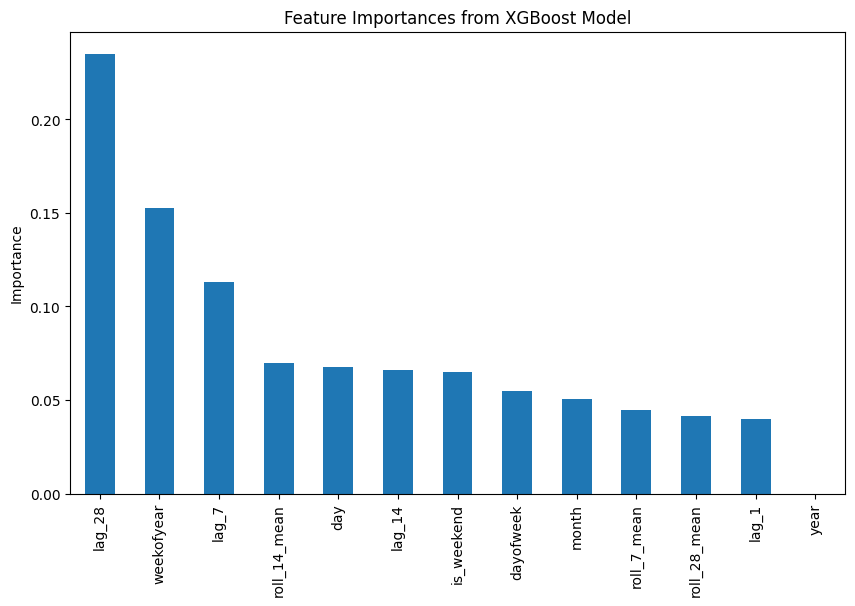

In [10]:
# 9 Explore Feature Importances
import matplotlib.pyplot as plt

if 'model' in locals() and hasattr(model, 'feature_importances_') and 'FEATURES' in locals():
    feature_importances = pd.Series(model.feature_importances_, index=FEATURES).sort_values(ascending=False)

    print("Feature Importances:")
    display(feature_importances)

    # Optional: Visualize feature importances
    plt.figure(figsize=(10, 6))
    feature_importances.plot(kind='bar')
    plt.title('Feature Importances from XGBoost Model')
    plt.ylabel('Importance')
    plt.show()
else:
    print("Model or features not available. Please ensure steps 7 and 8 were run successfully.")

In [11]:
# 10 Evaluate model
y_pred = model.predict(X_test_s)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")

# Attach predictions to test_df for inspection
test_out = test_df.copy()
test_out['pred'] = y_pred
display(test_out[[TARGET, 'pred']].head(10))

# Save eval results
eval_out_path = os.path.join(OUTPUT_DIR, 'eval_results.csv')
# Drop the existing 'date' column before resetting index
test_out.drop(columns=['date']).reset_index().to_csv(eval_out_path, index=False)
print("Saved test predictions to", eval_out_path)

Test RMSE: 21.1549
Test MAE:  14.8551


,daily_sales,pred
date,,
2014-01-01,0.0,75.889824
2014-01-02,57.0,65.361046
2014-01-03,62.0,50.589596
2014-01-04,73.0,50.695850
2014-01-05,81.0,68.161736
2014-01-06,55.0,46.227104
2014-01-07,62.0,38.897274
2014-01-08,54.0,47.304939
2014-01-09,43.0,39.984085


Saved test predictions to /content/drive/MyDrive/corporacion_favorita/results/eval_results.csv


In [12]:
# 11 Forecast Jan–Mar 2014 (recursive forecasting using lag features)
future_start = pd.to_datetime('2014-01-01')
future_end = pd.to_datetime('2014-03-31')
future_dates = pd.date_range(start=future_start, end=future_end, freq='D')

# If some of future dates are already in dataset and we have actuals, we can still produce forecasts.
# We'll build a dataframe starting from last date in historical data up to future_end so we can compute lags.
last_hist_date = df_feats.index.max()
print("Last historical date available:", last_hist_date)

# We'll work with a copy of df_feats extended to future_end (filling daily_sales na)
full_index = pd.date_range(start=df_feats.index.min(), end=future_end, freq='D')
work = df_feats.reindex(full_index).copy()
# Keep original historical daily_sales for known dates, future days will be filled iteratively
# Prepare for recursive forecasting
# We'll use the model and scaler to predict each future day in order
model_features = FEATURES

# Find starting point for recursion: use the last available real daily_sales value for lags
for d in pd.date_range(start=last_hist_date + pd.Timedelta(days=1), end=future_end):
    # prepare feature row for date d
    row_date = pd.Timestamp(d)
    # compute base date features
    row = {}
    # The 'date' column in 'work' is redundant with the index, remove it when creating the row data for prediction
    # row['date'] = row_date # Do not include date in the row data used for prediction
    row['day'] = row_date.day
    row['month'] = row_date.month
    row['year'] = row_date.year
    row['dayofweek'] = row_date.dayofweek
    row['is_weekend'] = int(row_date.dayofweek in (5,6))
    row['weekofyear'] = int(row_date.isocalendar()[1])

    # lags: use values available in work['daily_sales'] (historical or previously predicted)
    for lag in [1,7,14,28]:
        lag_idx = row_date - pd.Timedelta(days=lag)
        row[f'lag_{lag}'] = work.at[lag_idx, 'daily_sales'] if lag_idx in work.index else 0.0

    # rolling means take the previous days' values
    def rolling_mean(end_date, window):
        vals = []
        for back in range(1, window+1):
            idx = end_date - pd.Timedelta(days=back)
            if idx in work.index:
                vals.append(work.at[idx, 'daily_sales'])
        if len(vals) == 0:
            return 0.0
        return np.mean(vals)

    row['roll_7_mean'] = rolling_mean(row_date, 7)
    row['roll_14_mean'] = rolling_mean(row_date, 14)
    row['roll_28_mean'] = rolling_mean(row_date, 28)

    # create df, scale, predict
    X_row = np.array([row[c] for c in model_features]).reshape(1, -1)
    X_row_s = scaler.transform(X_row)
    pred_val = float(model.predict(X_row_s)[0])

    # store predicted value into work
    work.at[row_date, 'daily_sales'] = pred_val
    # also fill created features for potential later debugging/inspection
    # Only add features that were computed for the row, not the date index itself
    for k,v in row.items():
        if k != 'date': # Avoid adding the 'date' column again
            work.at[row_date, k] = v

print("Forecasting complete until", future_end)

# Extract forecasts for Jan-Mar 2014
# Select the index (date) and the predicted daily_sales, then rename the columns
forecast_df = work.loc[future_start:future_end, ['daily_sales']].copy()
forecast_df = forecast_df.reset_index().rename(columns={'index': 'date', 'daily_sales': 'predicted_sales'})

# Save forecasts
forecast_out_path = os.path.join(OUTPUT_DIR, 'forecast_2014_01_03.csv')
forecast_df.to_csv(forecast_out_path, index=False)
print("Saved forecast results to", forecast_out_path)
display(forecast_df.head(12))

Last historical date available: 2014-03-31 00:00:00
Forecasting complete until 2014-03-31 00:00:00
Saved forecast results to /content/drive/MyDrive/corporacion_favorita/results/forecast_2014_01_03.csv


,date,predicted_sales
0,2014-01-01,0.0
1,2014-01-02,57.0
2,2014-01-03,62.0
3,2014-01-04,73.0
4,2014-01-05,81.0
5,2014-01-06,55.0
6,2014-01-07,62.0
7,2014-01-08,54.0
8,2014-01-09,43.0
9,2014-01-10,36.0


In [13]:
# 12 Save model and artifacts (already saved model and scaler earlier)
# Save whole pipeline dict for convenience
pipeline_path = os.path.join(MODEL_DIR, 'pipeline_info.pkl')
pipeline = {
    'model_path': model_path,
    'scaler_path': scaler_path,
    'features': model_features,
    'trained_on_until': train_df.index.max()
}
joblib.dump(pipeline, pipeline_path)
print("Saved pipeline info to", pipeline_path)

Saved pipeline info to /content/drive/MyDrive/corporacion_favorita/model/pipeline_info.pkl


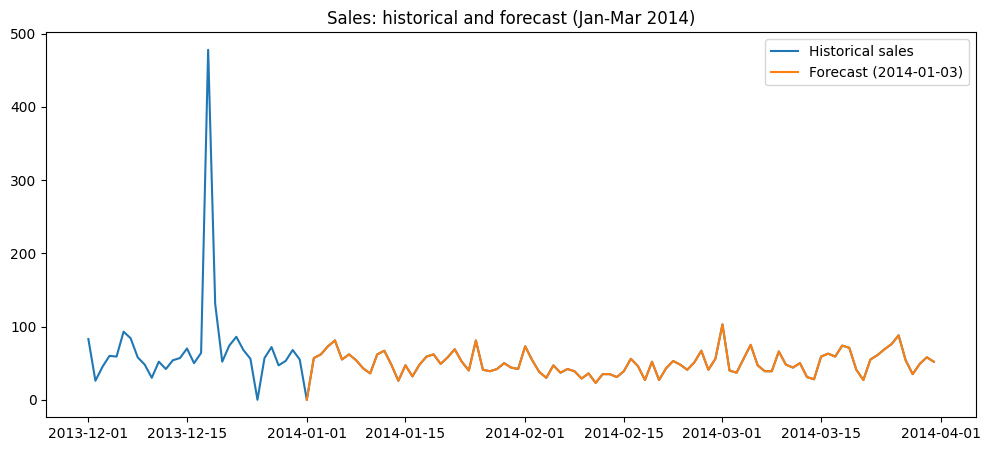

All done. Files created:
- Model: /content/drive/MyDrive/corporacion_favorita/model/xgb_model.pkl
- Scaler: /content/drive/MyDrive/corporacion_favorita/model/scaler.pkl
- Eval & preds: /content/drive/MyDrive/corporacion_favorita/results/eval_results.csv
- Forecast csv: /content/drive/MyDrive/corporacion_favorita/results/forecast_2014_01_03.csv
- Pipeline meta: /content/drive/MyDrive/corporacion_favorita/model/pipeline_info.pkl


In [14]:
# 13 Quick plots (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
# plot last 120 days of actual & preds (if exist)
hist_plot_start = max(df_feats.index.max() - pd.Timedelta(days=120), df_feats.index.min())
plt.plot(df_feats.loc[hist_plot_start:,'daily_sales'], label='Historical sales')
# overlay forecast (if beyond history)
plt.plot(forecast_df.set_index('date')['predicted_sales'], label='Forecast (2014-01-03)')
plt.legend()
plt.title('Sales: historical and forecast (Jan-Mar 2014)')
plt.show()

print("All done. Files created:")
print("- Model:", model_path)
print("- Scaler:", scaler_path)
print("- Eval & preds:", eval_out_path)
print("- Forecast csv:", forecast_out_path)
print("- Pipeline meta:", pipeline_path)
